(content:plotting_maps)=
# Plotting Maps

In this notebook, we will finally plot some visualizations based on [the post-processed collection previously created](content:post_process_collection). For that, we will use the python package `folium` (please install it with `pip install folium`).

In [16]:
import folium
import pandas as pd
import numpy as np
import base64
import io
import matplotlib.pyplot as plt

This simple map that we are going to plot will need two files:
1. [The post-processed collection (processed_top5_cities.csv)](content:post_process_collection)
2. The Geojson/Shapefiles/KML/Lat-long for locations. This information was included in the [original data (worldcities_fb_keys.csv)](content:json_creation), but could also be obtained by querying Facebook for [KMLs](content:listing_all_cities_states_in_a_country_region) or by other Websites, such as [GADM](https://gadm.org/data.html).

In [18]:
df_fb = pd.read_csv("processed_top5_cities.csv")
df_loc = pd.read_csv("worldcities_fb_keys.csv")

df = pd.merge(df_fb, df_loc, left_on="Key", right_on="key")
df.head()

Key         Name             Region                       FullLocation  \
0  2880782    Minato-ku              Tokyo               Minato-ku, Tokyo, JP   
1  2490299     New York           New York             New York, New York, US   
2  2673660  Mexico City   Distrito Federal  Mexico City, Distrito Federal, MX   
3  1035921       Mumbai        Maharashtra            Mumbai, Maharashtra, IN   
4   269969    São Paulo  São Paulo (state)   São Paulo, São Paulo (state), BR   

   both_18-40_2G  both_18-40_3G  both_18-40_4G  both_18-40_AllDevices  \
0           1000           1000           8400                  64000   
1           1000           4900         520000                3300000   
2           1200         160000        1000000                7600000   
3          11000          46000        5300000                9000000   
4           1000          45000         510000                5800000   

   both_18-40_Wifi  both_18-_2G  ...  population          id     fb_query  \
0            34000         1000  ...  35676000.0  1392685764        Tokyo   
1          1600000         1000  ...  19354922.0  1840034016     New York   
2          4800000         1700  ...  19028000.0  1484247881  Mexico City   
3          1700000        14000  ...  18978000.0  1356226629       Mumbai   
4          3700000         2000  ...  18845000.0  1076532519    São Paulo   

          name      key             region  region_id   country_name  \
0    Minato-ku  2880782              Tokyo       1922          Japan   
1     New York  2490299           New York       3875  United States   
2  Mexico City  2673660   Distrito Federal       2513         Mexico   
3       Mumbai  1035921        Maharashtra       1735          India   
4    São Paulo   269969  São Paulo (state)        460         Brazil   

   country_code  type  
0            JP  city  
1            US  city  
2            MX  city  
3            IN  city  
4            BR  city  

[5 rows x 83 columns]

## A Basic Map

Folium is an amazing Python tool that directly uses [leaflet](https://leafletjs.com/) JavaScritp library for iteractive maps. We recommend the reader to take a look at the [latest folium documentation](https://python-visualization.github.io/folium/quickstart.html) and [the various examples of how to use this library](https://nbviewer.jupyter.org/github/python-visualization/folium/tree/master/examples/).

A simple map for our use case is based on the following code that explores the `tooltip` and `popup` concepts on top of the markers of each city.

In [19]:
m = folium.Map(location=[0, 0], zoom_start=2, tiles="openstreetmap", control_scale = True)

for idx, row in df.iterrows():
    tooltip = 'City name: %s!' % (row["name"])
    html = "<h1>%s</h1>Total FB pop: %d" % (row["name"], row["both_18-_AllDevices"])
    popup = folium.Popup(html, max_width=450, min_width=450)

    folium.Marker([row["lat"], row["lng"]], popup=popup, tooltip=tooltip).add_to(m)
m

When any of the locations is clicked, a pop up showing the city name and the total Facebook audience is shown.
This number is based on the column **both_18-_AllDevices**, and as [explaned before](content:post_process_collection), it represents both male and female audience aged at least 18 years old and using any network to connect to Facebook. 

```{warning}
Note that the correct column name will depend on the criteria used in the collection!
```

## Improving the Basic Map

Next we will define a few functions to be able to plot a much more interesting map.
The functions ``getPie`` and ``getPyramid`` can be used in other contexts as well.
The parameter `get_encoded` is decide if these functions should return an image HTML encoded or not. For the maps, we will use `get_encoded=True`.

In [20]:
def getPie(labels, sizes, explode=None, title=None, get_encoded=True):
    
    # Pie chart, where the slices will be ordered and plotted counter-clockwise:
    # Examples:
    # labels = 'Frogs', 'Hogs', 'Dogs', 'Logs'
    # sizes = [15, 30, 45, 10]
    # explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

    
    def label_formant(pct, allvals):
        absolute = int(pct/100.*np.sum(allvals))
        return "{:.1f}%\n({:,d})".format(pct, absolute)
    
    # TODO: make it like a doughout
    # https://matplotlib.org/3.1.1/gallery/pie_and_polar_charts/pie_and_donut_labels.html
    
    fig1, ax1 = plt.subplots(figsize=(2,2))
    ax1.pie(sizes, explode=explode, labels=labels,
            autopct=lambda pct: label_formant(pct, sizes),
            shadow=True, startangle=90, counterclock=False, 
            wedgeprops = {'linewidth' : 2, 'edgecolor': "black", }
           )
    
    if title:
        ax1.set_title(title)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    if get_encoded:
        img_buffer = io.BytesIO()
        plt.savefig(img_buffer, format='png', transparent=True, bbox_inches="tight")
        img_buffer.seek(0)
        plt.close()
        
        return base64.b64encode(img_buffer.getvalue()).decode('UTF-8')
        
    else:
        return plt
    

<module 'matplotlib.pyplot' from '/home/palotti/.conda/envs/cp38/lib/python3.8/site-packages/matplotlib/pyplot.py'>

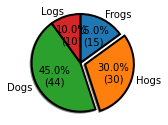

In [21]:
getPie(["Frogs", "Hogs", "Dogs", "Logs"], [15, 30, 45, 10], (0, 0.1, 0, 0), get_encoded=False)

In [22]:
getPie(["Frogs", "Hogs", "Dogs", "Logs"], [15, 30, 45, 10], (0, 0.1, 0, 0), get_encoded=True)[:1000]

'iVBORw0KGgoAAAANSUhEUgAAAKgAAAB9CAYAAAA2uCgoAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8vihELAAAACXBIWXMAAAsTAAALEwEAmpwYAAAvn0lEQVR4nO2deXhcVfnHP++9s2/Z0yRN2zRd2Rvaskhlt2UTWVREVASURVARRNCfK+4ii4IIguygILuIKFCgVChF6L6mTZfsezJZZrv3nt8fd5KmTdomadqZYD7Pkycz95577rkz3znL+77nHFFKMcYY6YqW6gKMMcaeGBPoGGnNmEDHSGvGBDpGWjMm0DHSmjGBjpHWjBqBikhnqsswxoFn1Ah0jP9NRrVARWSWiCwRkZUi8pyIZCWPz00ee1dEbhGR1cnjh4jIUhFZnjw/LbVPMMbeGNUCBR4BblRKHQ6sAn6UPP4gcKVS6ljA7JP+SuB3SqlZwByg6gCWdZ8QETP5w+r5K0l1mQ4EjlQXYLiISAaQqZR6K3noYeBvIpIJBJVS7ySPPwGclXz9LvB/IlIMPKuUKj+QZd5HIskfVj9ERABRSlkHtkj7n9Fegw6E7O6EUuoJ4GwgAvxLRE4ekRvaAjmgiEiJiKwTkbuBD4EJPd0ZEVklIhck02kicreIrBGRl0TkZRH5dPLcr0RkbbK789sD/QyDYdTWoEqpdhFpFZGPK6XeBr4IvKWUahWRDhE5Rim1BPhczzUiUgpUKKV+n3x9OLBwoPyTossDDkr+zUz+nwr4ARcQxP4MEyISAbqBSmB78m9b8v86YIPat8gcr4gsT77eAnwLmAFcopT6moicD8wCjgBygfdFZBFwHFACHAbkJ8vygIhkA+cCM5VSKtnypB2jSaA+EenbZ7wNuBi4R0R8QAVwSfLcZcB9ItIFvAm0J49fAHxBRBJAHXBzT2Yi4gZOwO4OzMYWY9Ygy+ZM/oWAAmDuAGkaRWQ

In [23]:
def getPyramid(y, labels, data_left, data_right, normalized=False, get_buffer=True):
    
    # E.g.:
    # y = [0-18, 19-25, 26+]
    # labels = [female, male]
    # data_left = [1000, 2000, 3000]
    # data_right = [2000, 5000, 1000]
    
    data_left = np.array(data_left)
    data_right = np.array(data_right)
    
    if normalized:
        data_left = data_left / data_left.sum()
        data_right = data_right / data_right.sum()
    
    assert data_left.shape == data_right.shape
    N = range(0, data_left.shape[0])
    
    fig1, ax1 = plt.subplots(figsize=(2,2))
    
    ax1.barh(N, -data_left, label=labels[0])
    ax1.barh(N, data_right, label=labels[1])
    
    ax1.set(yticks=N, yticklabels=y)
    
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(True)
    ax1.spines["top"]._linewidth = 2
    
    ax1.spines['left'].set_visible(False)
    ax1.spines['bottom'].set_visible(True)
    ax1.spines['bottom']._linewidth = 2
    
    ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=5)

    if get_buffer:
        img_buffer = io.BytesIO()
        plt.savefig(img_buffer, format='png', transparent=True, bbox_inches="tight")
        img_buffer.seek(0)
        plt.close()
        return base64.b64encode(img_buffer.getvalue()).decode('UTF-8')
        
    else:
        return plt


The function ``getHTML`` will render an HTML including images generated by these other functions.

In [29]:
def getHTML(row):
    
    total_pop = float(row['both_18-_AllDevices'])
    
    pie_gender = getPie(["Male", "Female"], [row["male_18-_AllDevices"], row["female_18-_AllDevices"]])
    pie_connectivity = getPie(["Wifi", "2G", "3G", "4G"], [row["both_18-_Wifi"], row["both_18-_2G"], 
                                                           row["both_18-_3G"], row["both_18-_4G"], ])
    pie_connectivity_male = getPie(["Wifi", "2G", "3G", "4G"], [row["male_18-_Wifi"], row["male_18-_2G"],
                                                                row["male_18-_3G"], row["male_18-_4G"]], 
                                   title="Connectivity (Male)")
    pie_connectivity_female = getPie(["Wifi", "2G", "3G", "4G"], [row["female_18-_Wifi"], row["female_18-_2G"],
                                                                  row["female_18-_3G"], row["female_18-_4G"],], 
                                     title="Connectivity (Female)")
    
    pie_age = getPie(["18-40", "41-54", "55+"], [row["both_18-40_AllDevices"], row["both_41-54_AllDevices"],
                                                          row["both_55-_AllDevices"]])
    
    pyramid_age = getPyramid(["18-40", "41-54", "55+"], ["female", "male"],
                             [row["female_18-40_AllDevices"], row["female_41-54_AllDevices"], row["female_55-_AllDevices"]],
                             [row["male_18-40_AllDevices"], row["male_41-54_AllDevices"], row["male_55-_AllDevices"]]
                             )
    
    pyramid_age_perc = getPyramid(["18-40", "41-54", "55+"], ["female", "male"],
                                  [row["female_18-40_AllDevices"], row["female_41-54_AllDevices"], row["female_55-_AllDevices"]],
                                  [row["male_18-40_AllDevices"], row["male_41-54_AllDevices"], row["male_55-_AllDevices"]],
                                  normalized=True)

    
    
    html = """
    <h3> <b> Location: </b> <i> {name} </i>  ({lat:.1f}, {lng:.1f}) </h3> </br>  
    <h5> <b>Total Population: </b> {total_pop:,} </br> </h5>
    
    
    <h5> <b> Gender Distribution: </b> </h5>
    <center><img src='data:image/png;base64,{pie_gender}'/></center>
    
    <h5> <b> Age Distribution </b> </h5>
    <center><img src='data:image/png;base64,{pie_age}'/></center>
    
    <h5> <b> Age Distribution per Gender</b> </h5>
    <center>
    <img src='data:image/png;base64,{pyramid_age}'/>
    <img src='data:image/png;base64,{pyramid_age_perc}'/>
    </center>
    
    
    
    <h5> <b> Connectivity </b> <\h5>
    <center><img src='data:image/png;base64,{pie_connectivity}'/></center>
    
    <h5> <b> Connectivity per Gender </b> <\h5>
    <center><img src='data:image/png;base64,{pie_connectivity_male}'/><img src='data:image/png;base64,{pie_connectivity_female}'/></center>
    
    
    
    """.format(name=row["name"], 
               lat=float(row["lat"]), lng=float(row["lng"]), 
               total_pop=total_pop,
               pie_gender=pie_gender,
               pie_age=pie_age,
               pyramid_age=pyramid_age,
               pyramid_age_perc=pyramid_age_perc,
               pie_connectivity=pie_connectivity,
               pie_connectivity_male=pie_connectivity_male,
               pie_connectivity_female=pie_connectivity_female,
               
              )

    # TRY TO FORMAT WITH https://docs.python.org/3/library/string.html#format-specification-mini-language
    return html


In [32]:
# There are many options for tile. Here we are using the first one, openstreetmaps
tile_options = ['openstreetmap', 'cartodbpositron', 'Mapbox Bright', 
                'Stamen Terrain', 'Stamen Toner', 'Stamen Watercolor',
                'Mapbox Control Room', 'CartoDB dark_matter', ]

tiles =  tile_options[0]

m = folium.Map(location=[0, 0], zoom_start=2, tiles=tiles, control_scale = True)


for idx, row in df.iterrows():
    html = getHTML(row)
    popup = folium.Popup(html, max_width=450, min_width=450)

    tooltip = '%s!' % (row["name"])

    folium.Marker([row["lat"], row["lng"]], popup=popup, tooltip=tooltip).add_to(m)

m

In [7]:
# It is much easier to see the outcome of this notebook as a HTML file.
m.save('connetivity_top5_cities.html')